# Baseline-Point2Point Training

### Load Libraries

In [37]:
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
from PIL import Image
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [38]:
# img_folder = "data/kid-playing-insect"
img_folder = "data/moving-box/frames/moving-box-uniform/32x32"
# img_folder = "data/kid-conversation"
# img_folder = "data/kid-swing/resized"
imgs = [p[2] for p in walk(img_folder)][0]
imgs = list(filter(lambda x: not x.startswith(".") and "." in x, imgs))
prefix, postfix = imgs[0].split("-")[0], imgs[0].split(".")[1]
print("Total Images: {}".format(len(imgs)))
print("From:         {}".format(imgs[0]))
print("To:           {}".format(imgs[-1]))

Total Images: 15
From:         001.jpeg
To:           015.jpeg


#### Set Gap

In [39]:
gap = 1  # size of gap to interpolate

assert gap%2==1, "gap must be an odd number, so that we can get the ground-truth mid-image!"
assert gap>0, "gap must be positive!"

### Load Image Data

In [40]:
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1]) - (len(imgs)-1)%(gap + 1)
total_imgs = to - base_index + 1
num_intervals = (to-base_index)//(gap + 1)

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))
assert gap < total_imgs, "gap must be smaller than length of total images"

Select Range:  1 -> 15 | 7 Intervals


In [41]:
def index_to_img(i):
    return "{}/{}.{}".format(img_folder, "%03d"%(base_index + i), postfix)

In [42]:
x_index = [i*gap for i in range(num_intervals + 1)]
mid_index = [x + (gap+1)//2 for x in x_index[:-1]]

x_imgs = np.array([misc.imread(index_to_img(i)) for i in x_index]).astype('float32')    # training images
y_imgs = np.array([misc.imread(index_to_img(i)) for i in mid_index]).astype('float32')  # ground truth of images in betwen
print("x_imgs shape: {}".format(x_imgs.shape))
print("y_imgs shape: {}".format(y_imgs.shape))

# x_imgs /= mean
# y_imgs /= mean

# x_imgs_all = np.array([misc.imread(index_to_img(i)) for i in range(total_imgs)]).astype('float32')    # training images
# mean = np.mean(x_imgs_all, axis=0)

# x_imgs -= mean
# y_imgs -= mean

x_imgs shape: (8, 32, 32, 3)
y_imgs shape: (7, 32, 32, 3)


## Prepare Training Data

#### Set Batch Size

In [43]:
batch_size = 5
assert batch_size <=num_intervals, "batch_size must be <= num_intervals, which is {}".format(num_intervals)

In [44]:
def sample():
    """
    Select a batch size of data-point from X and y
    """
    start = np.random.choice(list(range(num_intervals)), size = batch_size, replace=False)
    start_x = x_imgs[start,...]
    end_x = x_imgs[start + 1,...]
    """  average to get batch_x  """
    batch_x = (start_x + end_x)/2
    batch_y = y_imgs[start,...]
    return (batch_x, batch_y)

### Display Input

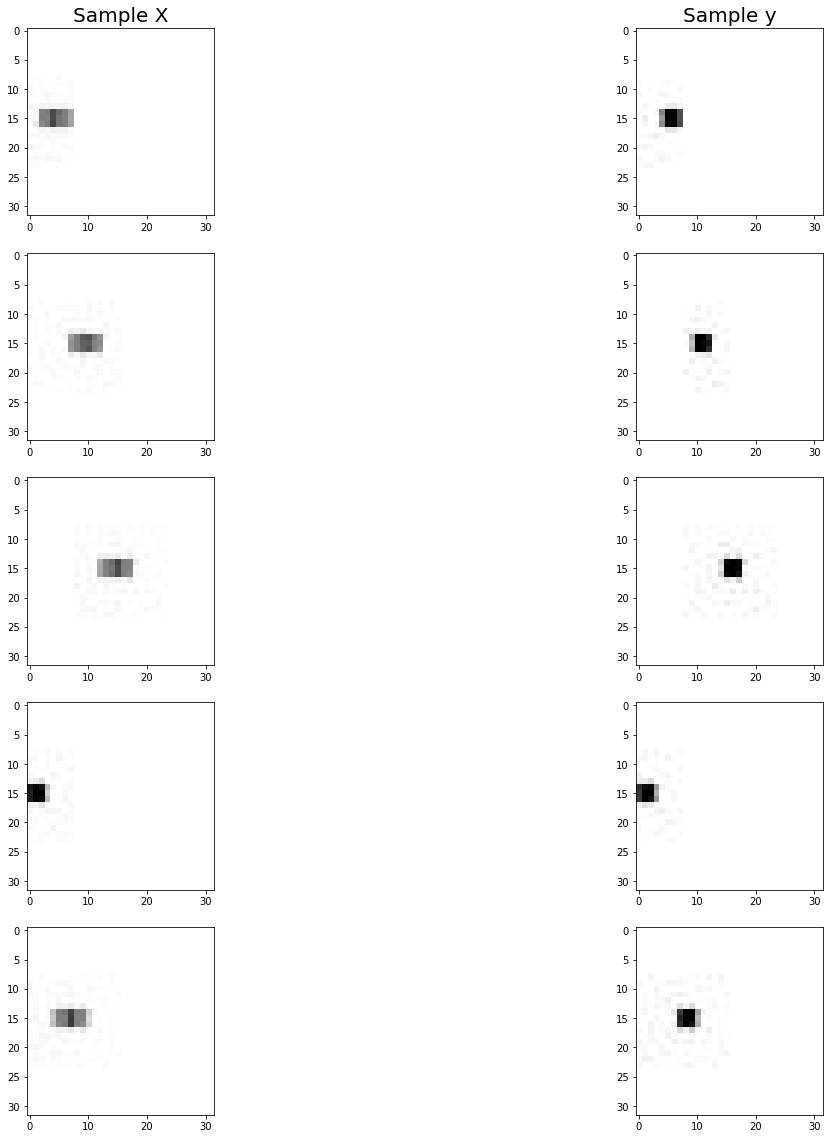

In [45]:
test_sample_x, test_sample_y = sample()
for i in range(batch_size):
    plt.subplot(batch_size, 2, i*2 + 1)
    if i == 0: plt.title("Sample X", fontsize=20)
    plt.imshow(test_sample_x[i].astype('uint8'))
    
    plt.subplot(batch_size, 2, i*2 + 2)
    if i == 0: plt.title("Sample y", fontsize=20)
    plt.imshow(test_sample_y[i].astype('uint8'))

## Train with Neural Network

In [46]:
# num_filter = 32
# def get_model(X):
#     X = tf.layers.conv2d(inputs=X, filters=num_filter, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
#     X = tf.tanh(X)
#     X = tf.layers.conv2d(inputs=X, filters=num_filter, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
#     X = tf.tanh(X)
#     output = tf.layers.conv2d(inputs=X, filters=3, kernel_size=[4, 4], strides = [1,1], padding="same", activation=None)
#     output = tf.tanh(output)
#     return output

In [47]:
hidden_size = np.product(x_imgs.shape[1:])
width, height, nChannel = x_imgs.shape[1:]
def get_model(X):
    X = tf.contrib.layers.flatten(X)
    X = tf.layers.dense(X, hidden_size, activation=None)
    X = tf.nn.relu(X)
#     X = tf.layers.dense(X, hidden_size, activation=None)
#     X = tf.nn.relu(X)
    output = tf.layers.dense(X, hidden_size, activation=None)
    output = tf.reshape(output, [-1, width, height, nChannel])
    return output

In [48]:
X = tf.placeholder(tf.float32, [None, width, height, 3])
y = tf.placeholder(tf.float32, [None, width, height, 3])
model = get_model(X)

#### Loss

In [49]:
# loss = tf.reduce_mean(tf.nn.l2_loss(model - y))
print(y.get_shape())
print(model.get_shape())
loss = tf.reduce_mean(tf.abs(model - y))
print(loss.get_shape())

(?, 32, 32, 3)
(?, 32, 32, 3)
()


#### Optimizer

In [68]:
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

### Run Model

In [69]:
iters = 1000
print_every = 10
loss_records = []
sess = sess =  tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(iters):
    sample_x, sample_y = sample()
    curr_loss, _ = sess.run([loss, train_step], {X: sample_x, y: sample_y})
    loss_records.append(curr_loss)
    if i%print_every == 0: print("Iteration {}: Loss = {:.3e}".format(i, curr_loss))

Iteration 0: Loss = 2.649e+02
Iteration 10: Loss = 2.119e+02
Iteration 20: Loss = 1.695e+02
Iteration 30: Loss = 1.341e+02
Iteration 40: Loss = 1.039e+02
Iteration 50: Loss = 7.887e+01
Iteration 60: Loss = 5.826e+01
Iteration 70: Loss = 4.308e+01
Iteration 80: Loss = 3.186e+01
Iteration 90: Loss = 2.335e+01
Iteration 100: Loss = 1.771e+01
Iteration 110: Loss = 1.419e+01
Iteration 120: Loss = 1.184e+01
Iteration 130: Loss = 1.014e+01
Iteration 140: Loss = 1.018e+01
Iteration 150: Loss = 9.033e+00
Iteration 160: Loss = 8.418e+00
Iteration 170: Loss = 8.703e+00
Iteration 180: Loss = 8.327e+00
Iteration 190: Loss = 8.108e+00
Iteration 200: Loss = 7.918e+00
Iteration 210: Loss = 8.033e+00
Iteration 220: Loss = 7.721e+00
Iteration 230: Loss = 7.776e+00
Iteration 240: Loss = 8.475e+00
Iteration 250: Loss = 7.771e+00
Iteration 260: Loss = 7.439e+00
Iteration 270: Loss = 7.664e+00
Iteration 280: Loss = 7.393e+00
Iteration 290: Loss = 7.362e+00
Iteration 300: Loss = 7.105e+00
Iteration 310: Loss

#### plot loss

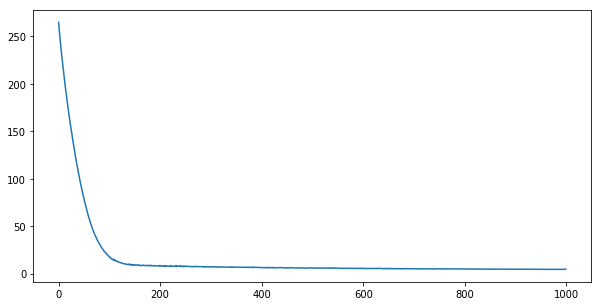

In [70]:
plt.figure(figsize=(10,5))
plt.plot(loss_records)
plt.show()

#### Display Training Result

In [71]:
sample_x, sample_y = sample()

train_output = sess.run(model, {X: sample_x, y: sample_y})

In [72]:
# train_output = (train_output + mean) * 255

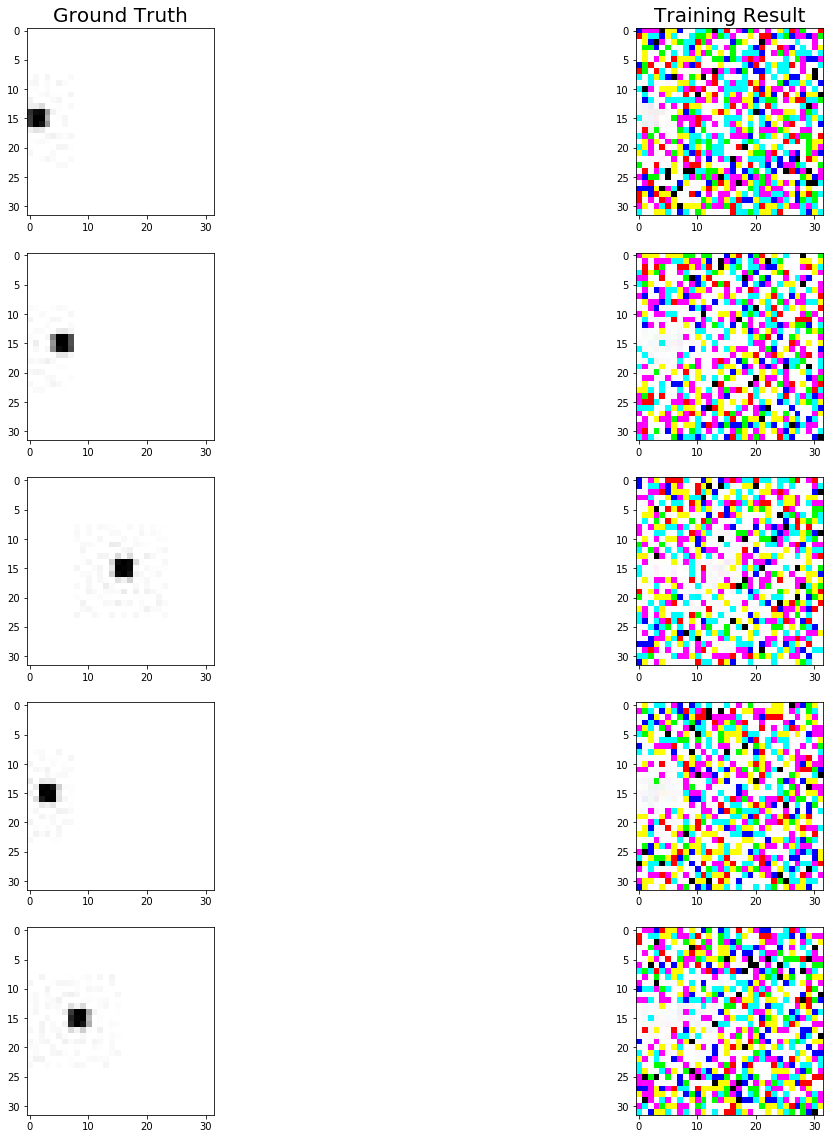

In [73]:
for i in range(batch_size):
    plt.subplot(batch_size, 2, i*2 + 1)
    if i == 0: plt.title("Ground Truth", fontsize=20)
    plt.imshow(sample_y[i].astype('uint8'))
    
    plt.subplot(batch_size, 2, i*2 + 2)
    if i == 0: plt.title("Training Result", fontsize=20)
#     train_output[i][train_output[i]<0] = 0
    plt.imshow(train_output[i].astype('uint8'))